In [21]:
%matplotlib qt 
# use qt to pop out raw scrolling visualizer

# Data analysis code

We will use this notebook as a basis for running analyses on some data of interest. There are a lot of underlying assumptions about statistics that we don't have the time to get into (there are entire courses in college for this!) so this is essentially just giving us what the code to run should be. 

Before we start running our own data, we'll use some N170 data that was previously collected to familiarize ourselves with the process.

In [19]:
import os, numpy as np,pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import math

# MNE functions
import mne
from mne import Epochs,find_events,Evoked,grand_average
from mne.viz import plot_compare_evokeds

# EEG-Notebooks functions
from eegnb.analysis.utils2 import load_data,plot_conditions,plot_highlight_regions
from eegnb.datasets import fetch_dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import ttest_ind, ttest_rel

## EEG data: Visualization

The visualization that we've already done for the N170 and P300 notebooks is our starting point. The visuals alone can actually tell us something about the areas that we'll be measuring! We'll start by looking at the 'raw data' (i.e. the data before we do any filtering and removing parts that aren't as good).

### Loading data

In [20]:
# loading the data block of choice. We'll start with one participant at a time:

eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    

# to load data from a specific subject and session:
subject = 24
session = 1

# make sure that these numbers are correct, or it will run from the last time you used 'subject' and 'session', 
# including from above!

raw = load_data(subject,session,
                experiment='visual-N170', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path)

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=236416
    Range : 0 ... 236415 =      0.000 ...   923.496 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=112636
    Range : 0 ... 112635 =      0.000 ...   439.980 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=192712
    Range : 0 ... 192711 =      0.000 ...   752.777 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=34576
    Range : 0 ... 34575 =      0.000 ...   135.059 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=72868
    Range : 0 ... 72867 =      0.000 

1110 events found
Event IDs: [1 2]
Setting up band-pass filter from 0.1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 40.00 Hz: -6.02, -6.02 dB



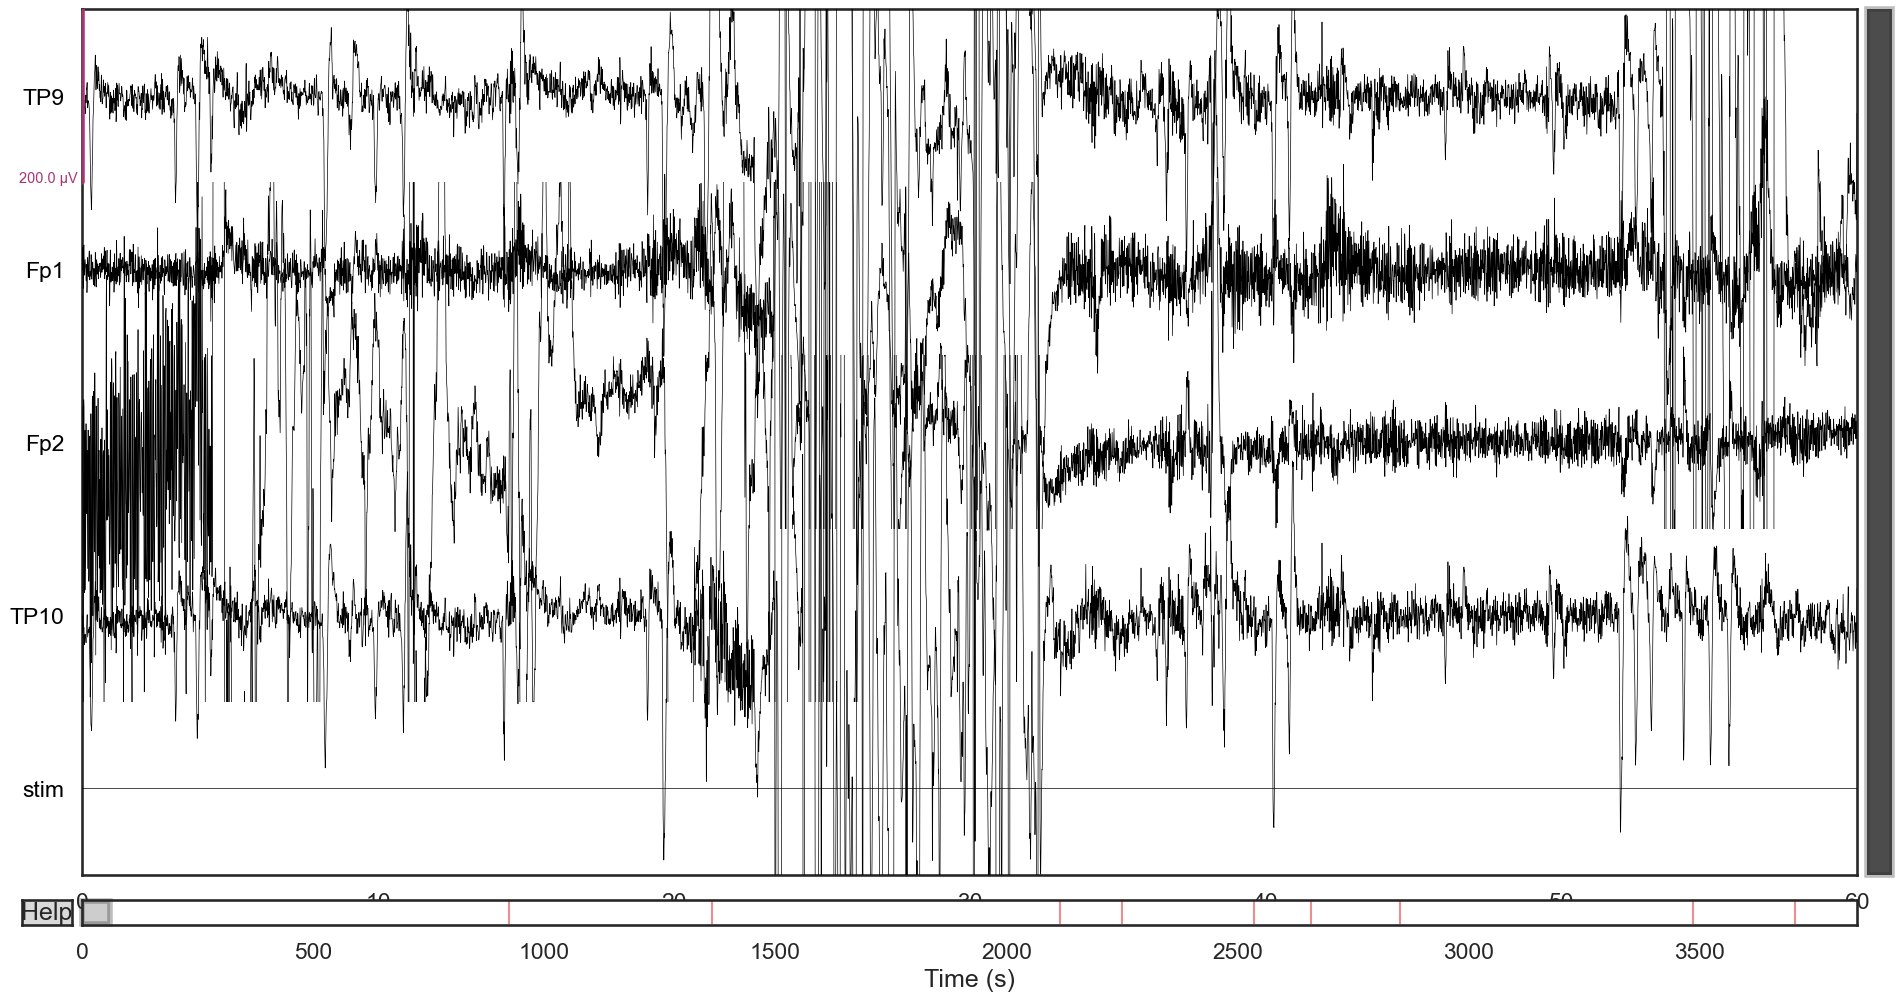

Channels marked as bad:
none


In [22]:
# visualize recording by looking at noise levels
events = mne.find_events(raw)
raw.plot(events = events, duration = 60, color = 'black', scalings = 100e-6, highpass = 0.1, lowpass = 40)

Effective window size : 8.000 (s)


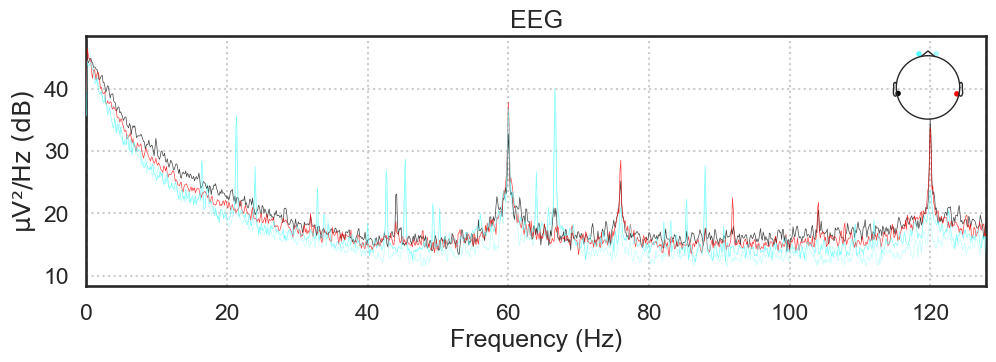

In [23]:
# plotting the raw data
raw.compute_psd(n_fft=int(8*raw.info["sfreq"])).plot() 

### Filtering the data

We've previously been using a certain command to 'filter' our data. 

Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Effective window size : 8.000 (s)


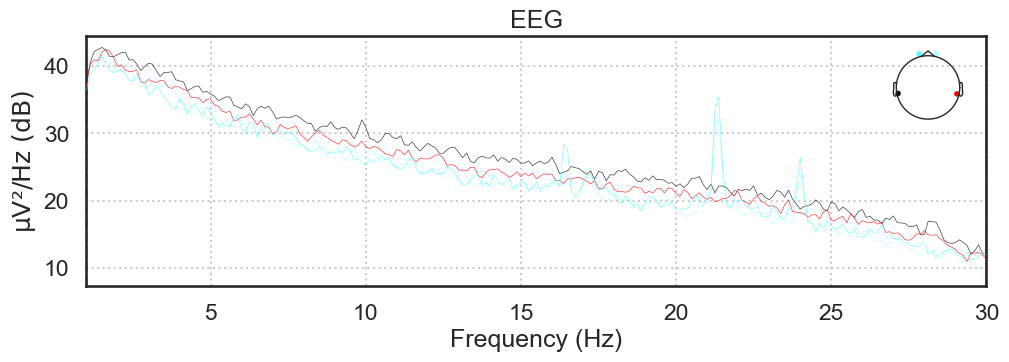

In [24]:
raw.filter(1,30, method='iir')
raw.compute_psd(n_fft=int(8*raw.info["sfreq"]), fmin=1, fmax=30).plot() 

### Epoching

A couple of notes about the below block: 

'reject' indicates the voltage change threshold after which we are rejecting a given epoch of data. Remember that blinks are big and actually aren't indicative of what we want to measure!

In [25]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw) # stim_channel allows us to choose which channel we're looking at
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=(-0.1, 0),
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

1110 events found
Event IDs: [1 2]
sample drop %:  40.0


Number of events,666
Events,Face: 326House: 340
Time range,-0.102 – 0.801 sec
Baseline,-0.100 – 0.000 sec


### Plotting

The conditions should be named for what you're plotting! For example, in the N170, the code 1 in the data represents when a house was pictured, while the code 2 represents when a face was pictured. However, in the P300, 1 represents a non-target and 2 represents a target.

In [29]:
face = epochs['Face'].average()
house = epochs['House'].average()

evokeds = dict(house=house, face=face)

fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
ax.set_xlim(-0.1, 0.8)
ax.axvspan(0.18, 0.26, color='grey', alpha=0.3) # highlighting region of interest

mne.viz.plot_compare_evokeds(evokeds, picks=[0,1], axes=ax, combine='mean')


combining channels using "mean"
combining channels using "mean"


[<Figure size 1000x500 with 1 Axes>]

We are actually looking forward a couple of things here. 

Is there a fluctuation where you would expect one, based on your study design and what you know? 
Are the faint bars overlapping or not?

After doing a quick look-see, you can tell if your data may or may not be too noisy. But either way, we can then also verify what we're observing by testing it statistically. 

## EEG data: Statistics

What we're trying to do is to see whether what we observe could have just happened by chance or not. For example, is there actually a difference between people looking at faces versus houses, or is it just that the EEG data randomly fluctuated a certain way and it happened to coincide when people looked at faces?

Because we are testing effects on waveforms that other researchers have characterized really well, we already have an idea of when and where the differences should happen. So we can actually just compare within specific blocks of time!

### Descriptive Statistics

There are a couple of things that people are interested in when measuring ERPs, namely the latency (how early the ERP happens) and the amplitude (how big the ERP is). With amplitude, there are also two ways of measuring, either the peak amplitude (the maximum size) or the mean amplitude (the average size over a standardized period of time).

We're going to look at mean amplitude as an initial statistic here. Rossion (2014) states that the N170 is typically observed between 120 and 200 milliseconds.

#### Mean Amplitude

In [27]:
time_windows = [(.16, .24), (.18, .26)] # the first window, in seconds, should reflect the start and end time of the typical window of interest; 
# the second is there since the muse has a bit of a delay

elecs = ["TP9", "TP10"] # we already know it mainly happens in the temporal electrodes
index = ['condition', 'epoch', 'time']

print(epochs.to_data_frame(index=index)[elecs])

channel                          TP9       TP10
condition epoch time                           
Face      0     -0.101562  18.702359   3.438392
                -0.097656  16.099557   2.129348
                -0.093750   9.694144   1.702032
                -0.089844   0.772769   1.200336
                -0.085938  -8.248018  -0.143080
...                              ...        ...
House     1107   0.785156  28.172930  12.764104
                 0.789062  27.244024  13.133577
                 0.792969  25.738138  13.306179
                 0.796875  24.245622  13.640360
                 0.800781  23.253135  14.537997

[154512 rows x 2 columns]


In [28]:
# we want to calculate things separately for houses and faces, so we need to separate that data accordingly
# epoch_df = epochs[Face].copy().crop(tmin, tmax).to_data_frame(index=index)
faces = epochs['Face'].average()
houses = epochs['House'].average()

printout = "{elec}, time: {tmin}-{tmax} s; faces {A: 3f} uv, houses {B: 3f} uv"

for (tmin, tmax) in time_windows:
    #faces_df = faces.copy().crop(tmin, tmax).to_data_frame(index=index)
    #houses_df = houses.copy().crop(tmin, tmax).to_data_frame(index=index)
    for elec in elecs:
        faces_df = faces.copy().pick(elec).crop(tmin, tmax)
        houses_df = houses.copy().pick(elec).crop(tmin, tmax)
        
        # extract data
        A = faces_df.data.mean() * 1e6
        B = houses_df.data.mean() * 1e6

        # display results
        print_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                          A=A, B=B)
        print(printout.format(**print_dict))

TP9, time: 0.16-0.24 s; faces  1.105649 uv, houses  2.714957 uv
TP10, time: 0.16-0.24 s; faces  1.235620 uv, houses  2.460945 uv
TP9, time: 0.18-0.26 s; faces  0.516386 uv, houses  2.233797 uv
TP10, time: 0.18-0.26 s; faces  0.437384 uv, houses  1.859523 uv


We'll also take this time to characterize peak amplitude and peak latency:

#### Peak Amplitude and Latency

Remember, peak amplitude can be affected by many variables. The peak amplitude is strongly affected by high-frequency noise (so when you see lots of rapid squiggles), and filtering the data excessively with a low-pass filter can affect where the peak actually is. So we want to make sure we're able to grab the time and amplitude in a window that actually covers the peak for the participant by visualizing. Pasting the above example here again:

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
ax.set_xlim(-0.1, 0.8)
ax.axvspan(0.16, 0.24, color='grey', alpha=0.3) # highlighting region of interest

mne.viz.plot_compare_evokeds(evokeds, picks=[0,1], axes=ax, combine='mean')

combining channels using "mean"
combining channels using "mean"


[<Figure size 1000x500 with 1 Axes>]

We can see here that the peak of the N170 is not captured well by the window we've identified, so we should probably shift the window back a bit (maybe between 180 and 260 milliseconds). Ideally, this comparison is done after you have seen the response from all of your participants. For the sake of this example, we will do it just for one, after looking at the grand average of all trials (both faces and houses).

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
ax.set_xlim(-0.1, 0.8)
ax.axvspan(0.18, 0.26, color='grey', alpha=0.3) # highlighting region of interest

grand = mne.grand_average([face, house])
mne.viz.plot_compare_evokeds(grand, picks=[0,1], axes=ax, combine='mean')

Identifying common channels ...
combining channels using "mean"


[<Figure size 1000x500 with 1 Axes>]

In [12]:
ch, lat, amp = face.get_peak(ch_type='eeg',tmin=0.18, tmax=0.26, mode='neg', return_amplitude=True)
print(ch)
print(str(lat * 1e3) + " ms") 
print(str(amp * 1e6) + " uV")

TP10
234.375 ms
-0.7608042613576004 uV


Our results here show us that the peak for this participant is in TP10 and at around 234 ms. This does put our peak of the N170 a bit further back (here about 60 ms delayed). If you are interested in comparing groups of participants, I would make sure to store this data separately for each participant. 

You may also be interested in getting the data for each electrode separately. The get_peak function takes one channel as the peak. In order to separate this, you will want to read the data for each channel in individually:

In [14]:
faces_tp9 = faces.copy().pick('TP9')
faces_tp10 = faces.copy().pick('TP10')
houses_tp9 = houses.copy().pick('TP9')
houses_tp10 = houses.copy().pick('TP10')
evo_list = [faces_tp9, faces_tp10, houses_tp9, houses_tp10]

In [ ]:
# optional (doesn't always work):
for evo in evo_list:
    ch, lat, amp = evo.get_peak(ch_type='eeg', tmin=0.18, tmax=0.26, mode='neg', return_amplitude=True)
    print(ch)
    print(str(lat * 1e3) + " ms") 
    print(str(amp * 1e6) + " uV")

In [15]:
print("Amplitude (uV)  Latency (ms)")
for evo in evo_list:
    evo2 = evo.copy().crop(tmin, tmax)
    idx_min = np.argmin(evo2.data, axis=1)  # min for each channel
    idx_max = np.argmax(evo2.data, axis=1)  # max for each channel
    
    val_min = np.min(evo2.data, axis=1)
    val_max = np.max(evo2.data, axis=1) 
    
    t_signal_min = evo2.times[idx_min]
    t_signal_max = evo2.times[idx_max]
    
    print(str(val_min * 1e6), str(t_signal_min * 1e3))

Amplitude (uV)  Latency (ms)
[-0.41702374] [238.28125]
[-0.76080426] [234.375]
[1.37380579] [238.28125]
[1.90944242] [246.09375]


### Hypothesis Testing

While there are lots of complicated hypothesis tests we could do, we'll stick to a simple one: comparing some of those amplitude values we just got. We might predict that there should be differences in amplitude for ERPs when someone is looking at faces versus houses, for example, because we have precedent for that!

In [16]:
report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")

faces = epochs['Face']
houses = epochs['House']

for (tmin, tmax) in time_windows:
    
    faces_df = faces.copy().crop(tmin, tmax).to_data_frame(index=index)
    houses_df = houses.copy().crop(tmin, tmax).to_data_frame(index=index)
    
    for elec in elecs:
        
        A = faces_df[elec]
        B = houses_df[elec]
        
        # conduct t test
        t, p = ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(epochs.events) - 2, t_val=t, p=p)
        print(report.format(**format_dict))


Targeted statistical test results:
TP9, time: 0.16-0.24 s; t(1272)=-6.103, p=0.000
TP10, time: 0.16-0.24 s; t(1272)=-12.891, p=0.000
TP9, time: 0.18-0.26 s; t(1272)=-10.055, p=0.000
TP10, time: 0.18-0.26 s; t(1272)=-16.283, p=0.000


### Group Visualization

Now that we have some sense of stats on individual data, can we take a look at the average waveforms? The starting code looks similar:

In [30]:
subs = [101, 102, 103, 111, 115, 121, 131, 152, 155, 856] # put all the numbers of the subjects you have here
house_list = []
face_list = []

# filter data
for sub in subs:
    raw = load_data(sub,1, # note: this assumes that each participant only has one session
            experiment='visual-N170', site='local', device_name='muse2_bfn',
            data_dir = eegnb_data_path, verbose=0)
    raw.filter(1,30, method='iir')
    
    # select events
    events = find_events(raw)
    event_id = {'House': 1, 'Face': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
            tmin=-0.1, tmax=0.8, baseline=(-0.1, 0),
            reject={'eeg': 75e-6}, preload=True, 
            verbose=False, picks=[0,3])
    
    # make evoked average
    houses = epochs['House'].average()
    faces = epochs['Face'].average()
    
    house_list.append(houses)
    face_list.append(faces)

evokeds = {'House': house_list, 'Face': face_list}

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

294 events found
Event IDs: [1 2]
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

291 events found
Event IDs: [1 2]


In [31]:
# using mne.grand_average() to combine subjects
picks=['TP9', 'TP10']

h_grand_average = grand_average(evokeds['House'])
f_grand_average = grand_average(evokeds['Face'])
grand = dict(house=h_grand_average, face=f_grand_average)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim(-0.1, 0.8)
ax.set_ylim(-3, 5)
ax.axvspan(0.17, 0.25, color='grey', alpha=0.3) # highlighting region of interest
plot_compare_evokeds(evokeds, combine='mean', axes=ax, picks=picks)

Identifying common channels ...
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"


[<Figure size 1000x500 with 1 Axes>]

And there! That's the visualization of all of the trials that we have for each person.

### Group Statistics

So far what we've been doing is data from one subject. That's good and all, but we collected data from multiple subjects! All we need to do is take what we've done for one subject and expand it to the entire dataset. 

One simple way of doing this is repeating a similar code that we did above and looping through all the participants. At the end, we can gather all of the averages we've made and average them together! 

In [31]:
# First, we have to determine the time window that best captures the amplitude changes across all participants. We can do this by doing a grand average of all of the conditions:

fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
ax.set_xlim(-0.1, 0.8)
ax.axvspan(0.18, 0.26, color='grey', alpha=0.3) # highlighting region of interest

grand = mne.grand_average([f_grand_average, h_grand_average])
mne.viz.plot_compare_evokeds(grand, picks=[0,1], axes=ax, combine='mean')

Identifying common channels ...
combining channels using "mean"


[<Figure size 1000x500 with 1 Axes>]

It looks like the 180-260ms period captures a dip that could be taken as the N170, so we'll use that as our time window moving forward.

In [ ]:
subs = [1, 2] # put all the numbers of the subjects you have here
face_TP9 = []
face_TP10 = []
house_TP9 = []
house_TP10 = []

time_windows = [(.18, .26)] 
elecs = ["TP9", "TP10"] 
index = ['condition', 'epoch', 'time']

sub_count = 0

for sub in subs:
    print(sub)
    
    sub_count += 1
    
    # load raw file
    raw = load_data(sub,1, # note: this assumes that each participant only has one session
                experiment='visual-N170', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path, verbose=0)
    
    # filter data
    raw.filter(1,30, method='iir')
    
    # select events
    events = find_events(raw)
    event_id = {'House': 1, 'Face': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,3])
    
    # generate mean values
    faces = epochs['Face'].average()
    houses = epochs['House'].average()
    
    for (tmin, tmax) in time_windows:
    
        #faces_df = faces.copy().crop(tmin, tmax).to_data_frame(index=index)
        #houses_df = houses.copy().crop(tmin, tmax).to_data_frame(index=index)
        
        for elec in elecs:
            
            faces_df = faces.copy().pick(elec).crop(tmin, tmax)
            houses_df = houses.copy().pick(elec).crop(tmin, tmax)            
            
            A = faces_df.data.mean() * 1e6
            B = houses_df.data.mean() * 1e6
            
            if elec == 'TP9':
                face_TP9.append(A)
                house_TP9.append(B)
            elif elec == 'TP10':
                face_TP10.append(A)
                house_TP10.append(B)

In [21]:
# here we are averaging all of the 'mean values' for each participant instead of considering every stimulus epoch separately.
# we can do that, but it's not as reflective of how we typically end up testing our values
grandavg_face_TP9 = np.nanmean(face_TP9,0)
grandavg_house_TP9 = np.nanmean(house_TP9,0)
grandavg_face_TP10 = np.nanmean(face_TP10,0)
grandavg_house_TP10 = np.nanmean(house_TP10,0)

#t_9, p_9 = ttest_ind(face_TP9, house_TP9) # we are doing a t-test to compare faces vs. houses
#t_10, p_10 = ttest_ind(face_TP10, house_TP10)

# technically face and house are paired comparisons, so we should be using a paired test:
t_9, p_9 = ttest_rel(face_TP9, house_TP9)
t_10, p_10 = ttest_rel(face_TP10, house_TP10)

We now have some combined values! This is good. We can see how big the differences are between the mean values we've gotten.

In [22]:
# here we are comparing between conditions (e.g. face vs. house)

print('Face TP9 Mean:', grandavg_face_TP9)
print('House TP9 Mean:', grandavg_house_TP9)
print('t(',len(subs),') =',t_9,', p = ',p_9)

print('Face TP10 Mean:', grandavg_face_TP10)
print('House TP10 Mean:', grandavg_house_TP10)
print('t(',len(subs),') =',t_10,', p = ',p_10)

Face TP9 Mean: 0.1438544706246057
House TP9 Mean: 1.192720645386634
t( 2 ) = -4.415384028083325 , p =  0.1417901867148746
Face TP10 Mean: -0.14857546489885234
House TP10 Mean: 1.9807065051801032
t( 2 ) = -5.0796941480899225 , p =  0.12374403549376375


We'll talk about what these mean and how to report them when we are making our posters!